# **IMPORTING THE LIBRARIES**

In [ ]:
!pip install keras-tuner --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import keras
import pickle
from sklearn import metrics
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.manifold import TSNE
from prettytable import PrettyTable
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# Import different classifiers
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, Conv1D, MaxPooling1D, Flatten
from keras.layers import Dense, Dropout
from keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold


# **LOADING THE DATASET**

In [ ]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [ ]:
DATADIR='UCI HAR Dataset'

In [ ]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, sep='\s+', header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'/content/drive/MyDrive/UCI HAR/{DATADIR}/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).to_numpy()
        )

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [ ]:
def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'/content/drive/MyDrive/UCI HAR/{DATADIR}/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).to_numpy()

In [ ]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [ ]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [ ]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [ ]:
# Loading the train and test data
trainX,testX, trainy, testy = load_data()

In [ ]:
trainy.shape

(7352, 6)

In [ ]:
timesteps = len(trainX[0])
input_dim = len(trainX[0][0])
n_classes = _count_classes(trainy)

print(timesteps)
print(input_dim)
print(len(trainX))

128
9
7352


In [ ]:
print("trainX shape: ",trainX.shape)
print("trainy shape: ", trainy.shape)
print("testX shape: ", testX.shape)
print("testy shape: ", testy.shape)

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


In [ ]:
trainy

array([[False, False, False, False,  True, False],
       [False, False, False, False,  True, False],
       [False, False, False, False,  True, False],
       ...,
       [False,  True, False, False, False, False],
       [False,  True, False, False, False, False],
       [False,  True, False, False, False, False]])

In [ ]:
# X_train = trainX[:, :, :6]
# X_test = testX[:, :, :6]
X_train = trainX
X_test = testX
y_train = trainy
y_test = testy

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7352, 128, 9)
(7352, 6)
(2947, 128, 9)
(2947, 6)


# **VISUALIZATION OF THE DATASET**

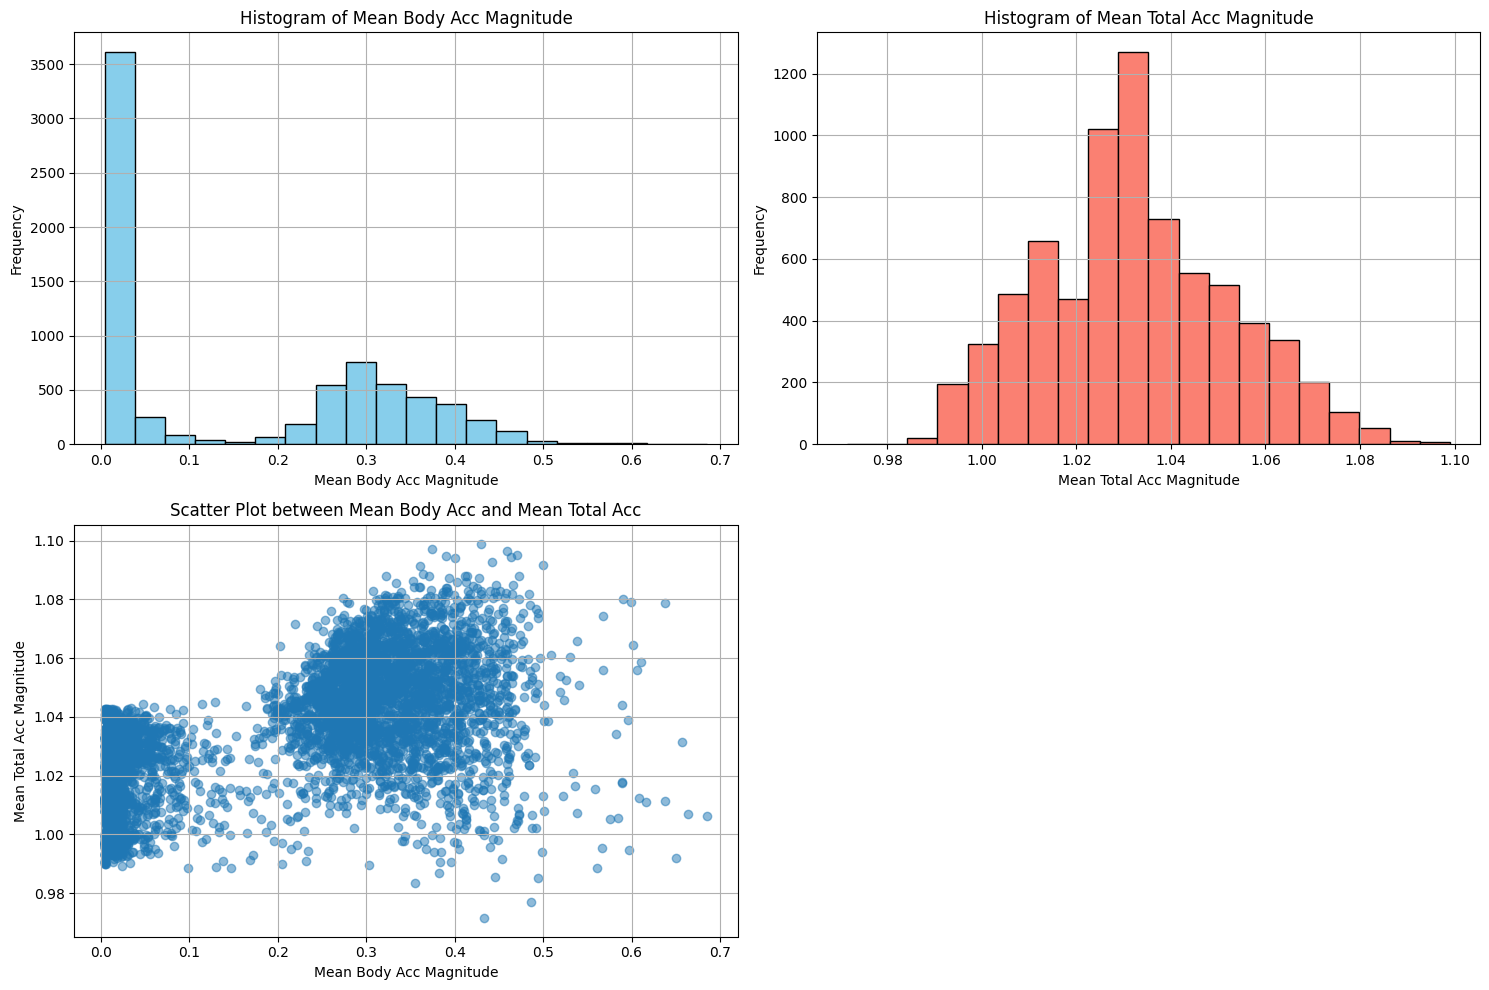

In [ ]:
# Calculate mean body acceleration magnitude
trainX_mean_body_acc = np.mean(np.sqrt(trainX[:, :, 0]**2 + trainX[:, :, 1]**2 + trainX[:, :, 2]**2), axis=1)

# Calculate mean total acceleration magnitude
trainX_mean_total_acc = np.mean(np.sqrt(trainX[:, :, 6]**2 + trainX[:, :, 7]**2 + trainX[:, :, 8]**2), axis=1)

# Create a figure and axes for subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Histogram for Mean Body Acc Magnitude
axes[0, 0].hist(trainX_mean_body_acc, bins=20, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Mean Body Acc Magnitude')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Histogram of Mean Body Acc Magnitude')
axes[0, 0].grid(True)

# Histogram for Mean Total Acc Magnitude
axes[0, 1].hist(trainX_mean_total_acc, bins=20, color='salmon', edgecolor='black')
axes[0, 1].set_xlabel('Mean Total Acc Magnitude')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Histogram of Mean Total Acc Magnitude')
axes[0, 1].grid(True)

# Scatter plot
axes[1, 0].scatter(trainX_mean_body_acc, trainX_mean_total_acc, alpha=0.5)
axes[1, 0].set_xlabel('Mean Body Acc Magnitude')
axes[1, 0].set_ylabel('Mean Total Acc Magnitude')
axes[1, 0].set_title('Scatter Plot between Mean Body Acc and Mean Total Acc')
axes[1, 0].grid(True)

# Hide empty subplot
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


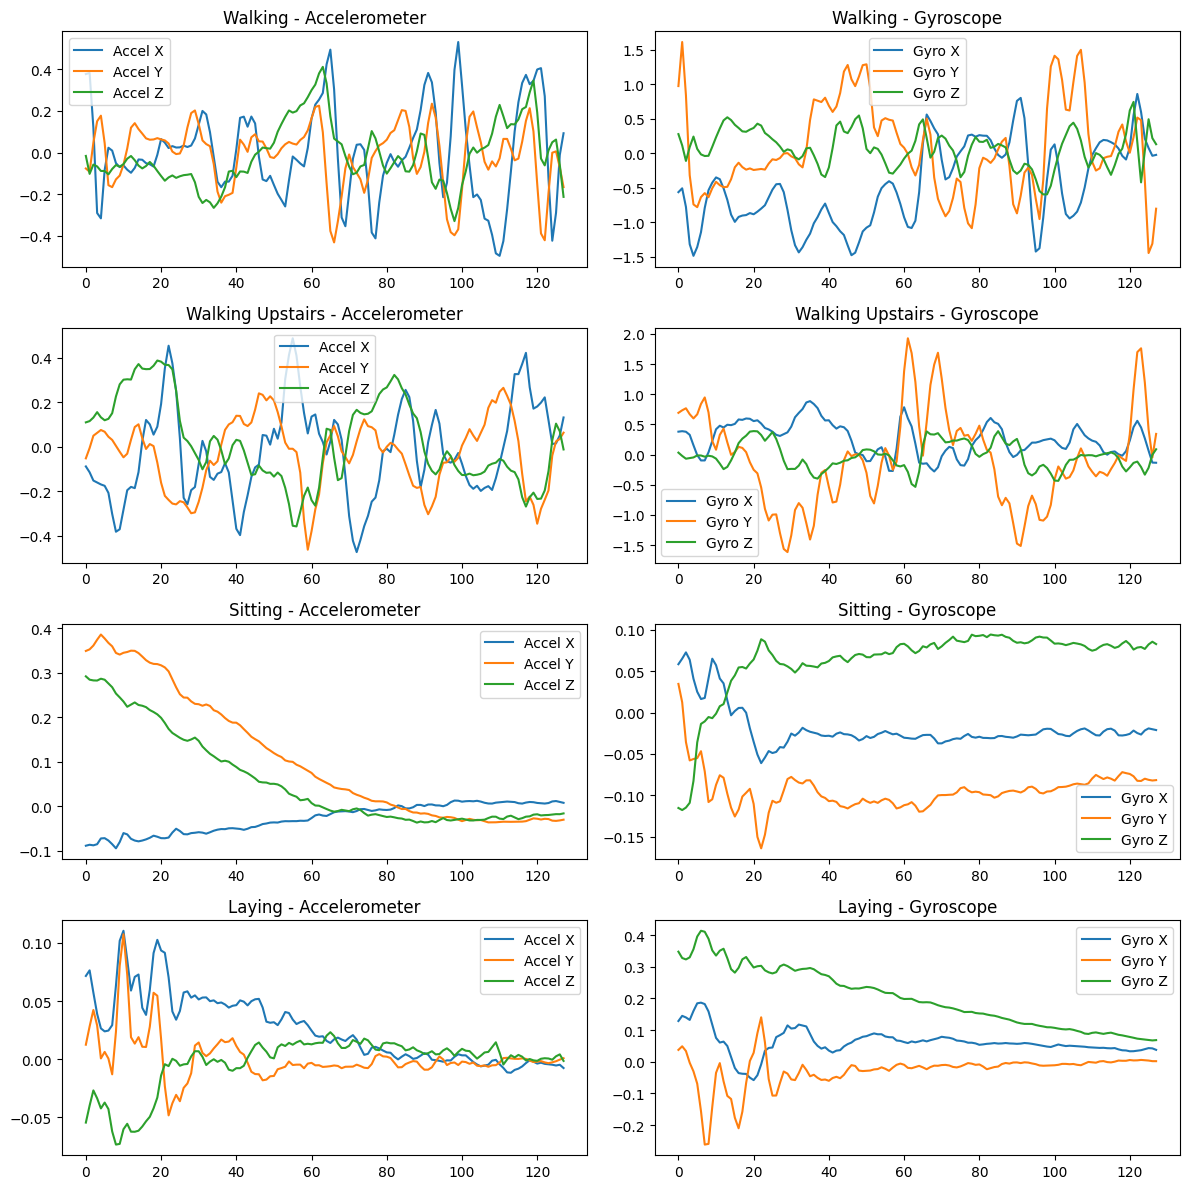

In [ ]:
# Adjusted activity dictionary if labels start at 0 instead of 1
activity = {
    0: 'Walking',
    1: 'Walking Upstairs',
    2: 'Walking Downstairs',
    3: 'Sitting',
    4: 'Standing',
    5: 'Laying'
}

# Convert one-hot to label index
y_train_labels = np.argmax(y_train, axis=1)

# Use valid activity indices based on label encoding (starting at 0)
selected_activities = [0, 1, 3, 5]  # Walking, Upstairs, Sitting, Laying

# Find sample indices for each selected activity
sample_indices = [np.where(y_train_labels == act)[0][0] for act in selected_activities]

# Plot
fig, axes = plt.subplots(len(selected_activities), 2, figsize=(12, 3 * len(selected_activities)))

for i, idx in enumerate(sample_indices):
    sample = X_train[idx]  # shape: (128, 9)
    acc = sample[:, :3]    # Accel: X, Y, Z
    gyro = sample[:, 3:6]  # Gyro: X, Y, Z

    # Plot Accelerometer
    axes[i, 0].plot(acc[:, 0], label='Accel X')
    axes[i, 0].plot(acc[:, 1], label='Accel Y')
    axes[i, 0].plot(acc[:, 2], label='Accel Z')
    axes[i, 0].set_title(f'{activity[selected_activities[i]]} - Accelerometer')
    axes[i, 0].legend()

    # Plot Gyroscope
    axes[i, 1].plot(gyro[:, 0], label='Gyro X')
    axes[i, 1].plot(gyro[:, 1], label='Gyro Y')
    axes[i, 1].plot(gyro[:, 2], label='Gyro Z')
    axes[i, 1].set_title(f'{activity[selected_activities[i]]} - Gyroscope')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()


In [ ]:
activity = {
        1: 'Walking',
        2: 'Walking Upstairs',
        3: 'Walking Downstairs',
        4: 'Sitting',
        5: 'Standing',
        6: 'Laying'}

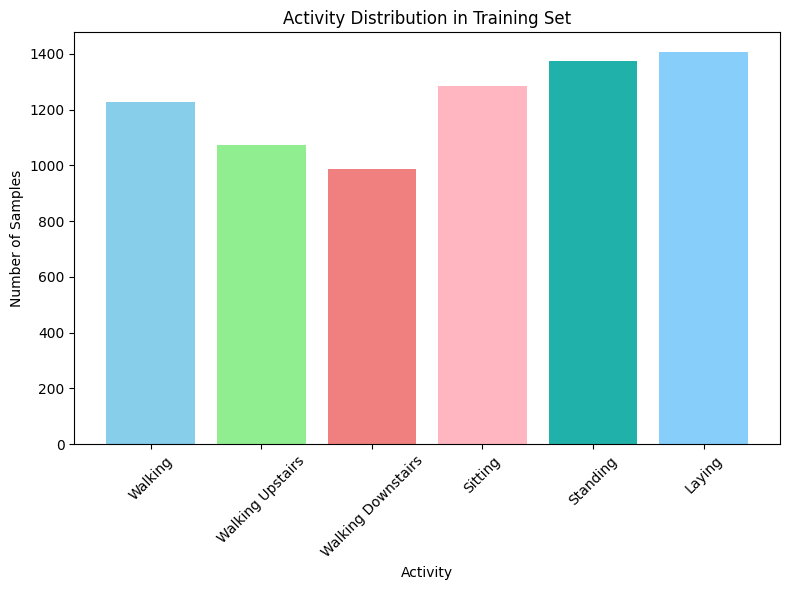

In [ ]:
# Assuming `trainy` is the one-hot encoded labels for training data
# We'll count the occurrences of each activity in the training set
activity_counts = np.sum(trainy, axis=0)

# Mapping the counts to activity names
activity_names = [activity[i + 1] for i in range(len(activity_counts))]

# Define a list of colors for each activity
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightpink', 'lightseagreen', 'lightskyblue']

# Plotting the distribution of activities with different colors
plt.figure(figsize=(8, 6))
bars = plt.bar(activity_names, activity_counts, color=colors)
plt.xlabel('Activity')
plt.ylabel('Number of Samples')
plt.title('Activity Distribution in Training Set')
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


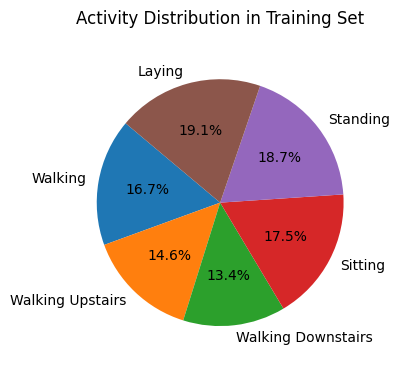

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Count the occurrences of each activity
activity_counts = np.sum(trainy, axis=0)

# Map the counts to activity names
activity_names = [activity[i + 1] for i in range(len(activity_counts))]

# Use a distinguishable colormap
cmap = plt.get_cmap('tab10')  # or 'Set3', 'Paired', etc.
colors = [cmap(i) for i in range(len(activity_counts))]

# Plotting the distribution as a pie chart
plt.figure(figsize=(4, 4))
plt.pie(activity_counts, labels=activity_names, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Activity Distribution in Training Set')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular

# Show the plot
plt.tight_layout()
plt.show()


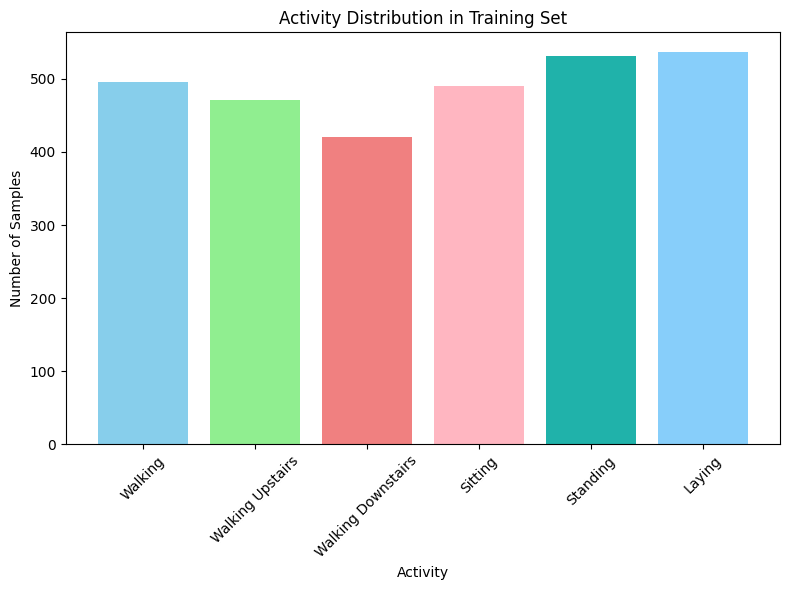

In [ ]:
# Assuming `trainy` is the one-hot encoded labels for training data
# We'll count the occurrences of each activity in the training set
activity_counts = np.sum(testy, axis=0)

# Mapping the counts to activity names
activity_names = [activity[i + 1] for i in range(len(activity_counts))]

# Define a list of colors for each activity
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightpink', 'lightseagreen', 'lightskyblue']

# Plotting the distribution of activities with different colors
plt.figure(figsize=(8, 6))
bars = plt.bar(activity_names, activity_counts, color=colors)
plt.xlabel('Activity')
plt.ylabel('Number of Samples')
plt.title('Activity Distribution in Training Set')
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd

# Convert one-hot to label encoding (e.g., [0,0,1,0,0,0] → 2)
y_train_labels = np.argmax(y_train, axis=1)  # Shape: (7352,)
y_test_labels = np.argmax(y_test, axis=1)    # Shape: (2947,)

# Repeat each label 128 times to match the number of timesteps
y_train_repeated = np.repeat(y_train_labels, repeats=128)  # Shape: (7352*128,)
y_test_repeated = np.repeat(y_test_labels, repeats=128)    # Shape: (2947*128,)

# Reshape X to 2D: (samples × timesteps, features)
X_train_flat = X_train.reshape(-1, 9)  # Shape: (7352*128, 9)
X_test_flat = X_test.reshape(-1, 9)    # Shape: (2947*128, 9)

# Create DataFrames
train_df = pd.DataFrame(X_train_flat, columns=[f'sensor_{i+1}' for i in range(9)])
train_df['label'] = y_train_repeated

test_df = pd.DataFrame(X_test_flat, columns=[f'sensor_{i+1}' for i in range(9)])
test_df['label'] = y_test_repeated

# Merge into single DataFrame
dtf = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


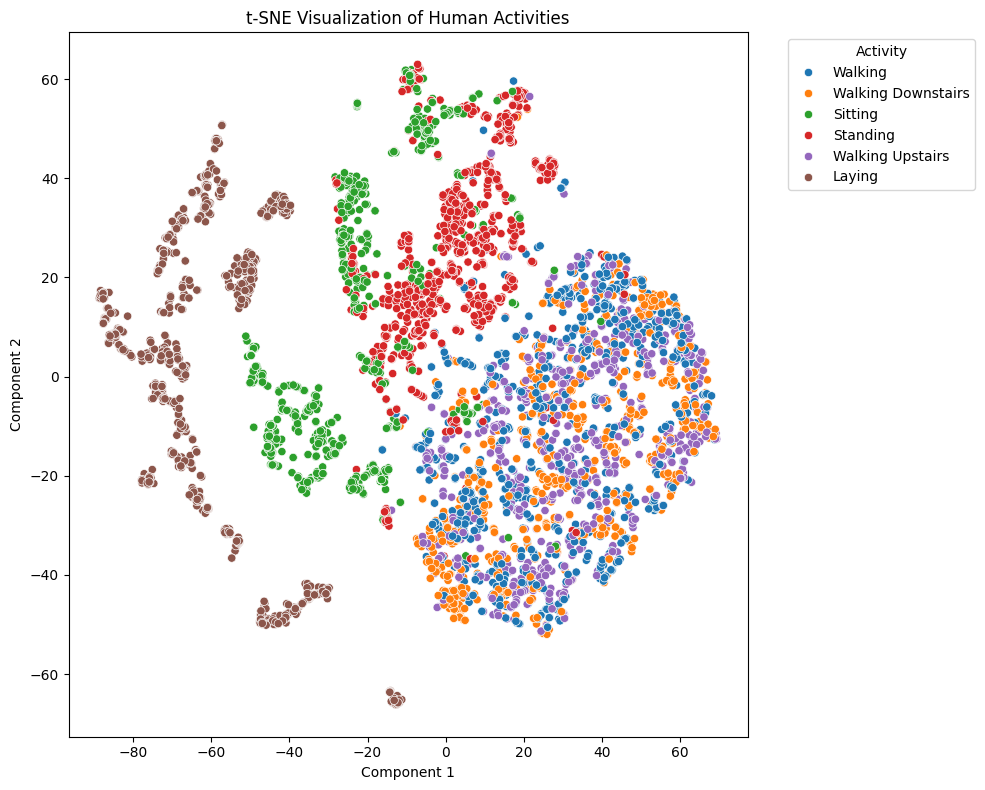

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

# Your activity mapping
activity = {
    1: 'Walking',
    2: 'Walking Upstairs',
    3: 'Walking Downstairs',
    4: 'Sitting',
    5: 'Standing',
    6: 'Laying'
}

# Features and labels
X = dtf.iloc[:, :-1].values
y = dtf['label'].values

# Sample for faster plotting
X_sampled, y_sampled = resample(X, y, n_samples=5000, stratify=y, random_state=42)

# Convert labels to activity names
activity_labels = [activity[i + 1] for i in y_sampled]

# t-SNE projection
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_embedded = tsne.fit_transform(X_sampled)

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1],
                hue=activity_labels, palette='tab10', legend='full')
plt.title("t-SNE Visualization of Human Activities")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Activity", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# **CNN MODEL**

In [ ]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = metrics.confusion_matrix(y_test, y_scores)
    print("**** Classification Report ****")
    print(metrics.classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Your input variables (just for clarity)
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

def build_model(hp):
    input_layer = Input(shape=(n_timesteps, n_features))  # (128, 6)

    # First Conv1D layer
    x = Conv1D(
        filters=hp.Choice('filters_1', values=[32, 64, 128]),
        kernel_size=hp.Choice('kernel_size_1', values=[3, 4, 5]),
        activation='relu'
    )(input_layer)

    # Second Conv1D layer
    x = Conv1D(
        filters=hp.Choice('filters_2', values=[32, 64, 128]),
        kernel_size=hp.Choice('kernel_size_2', values=[3, 4, 5]),
        activation='relu'
    )(x)

    # Dropout
    x = Dropout(hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1))(x)

    # MaxPooling
    x = MaxPooling1D(pool_size=hp.Choice('pool_size', values=[2, 3]))(x)

    x = Flatten()(x)

    # Dense feature layer
    feature_layer = Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=32),
        activation='relu',
        name='feature_layer'
    )(x)

    # Output layer
    output_layer = Dense(n_outputs, activation='softmax')(feature_layer)

    # Define the model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(
            learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
        ),
        metrics=['accuracy']
    )

    return model

# Instantiate tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,          # Try 20 different models
    executions_per_trial=2, # Each model is trained twice to reduce randomness
    directory='tuner_dir',
    project_name='cnn_timeseries_tuning'
)

# EarlyStopping callback
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Search for best model
tuner.search(X_train, y_train,
             epochs=30,
             validation_split=0.2,
             callbacks=[early_stopping])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Print best hyperparameters
best_hps = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameters:")
print(best_hps.values)


Trial 20 Complete [00h 10m 27s]
val_accuracy: 0.7226376831531525

Best val_accuracy So Far: 0.9313392341136932
Total elapsed time: 02h 44m 35s
Best Hyperparameters:
{'filters_1': 128, 'kernel_size_1': 5, 'filters_2': 128, 'kernel_size_2': 4, 'dropout_rate': 0.6000000000000001, 'pool_size': 3, 'dense_units': 128, 'learning_rate': 0.0004478774645296182}


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


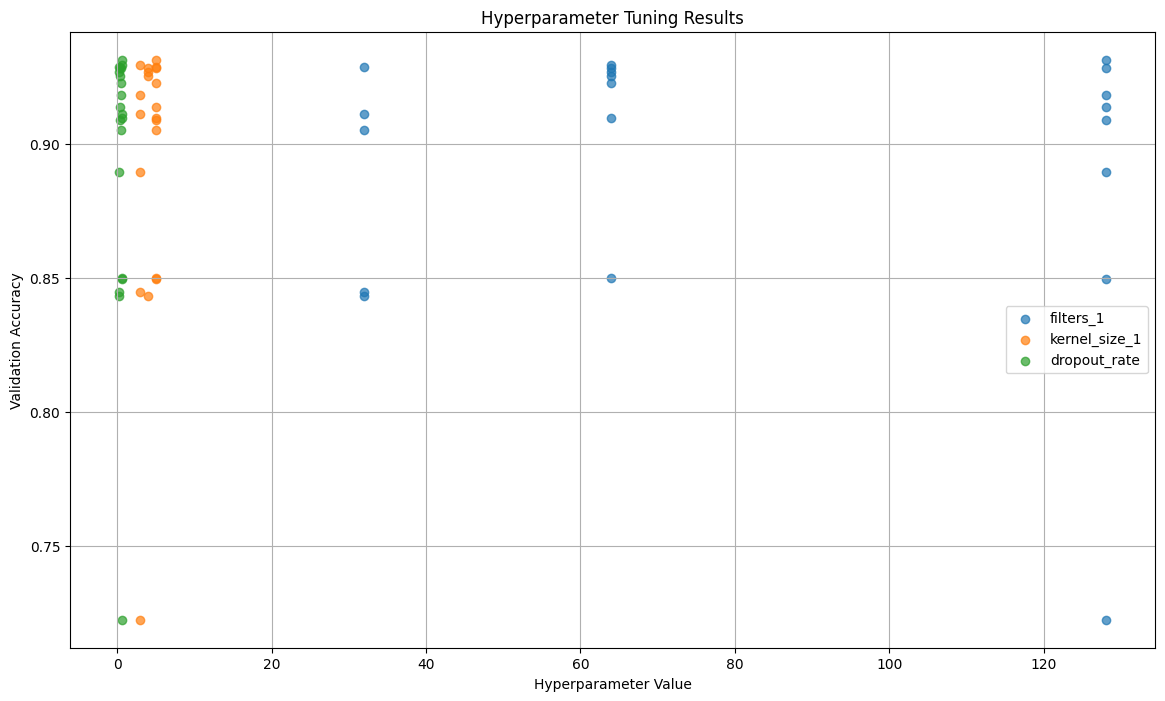

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Extract trial information from tuner
trials = tuner.oracle.trials  # Get all the trials

# Step 2: Extract relevant info for plotting
results = []
for trial in trials.values():
    # Extract hyperparameters
    trial_hyperparameters = trial.hyperparameters.values
    # Extract validation accuracy (it should be stored in the metrics)

    # Access the best value of 'val_accuracy' from the trial's metrics
    val_accuracy = trial.metrics.get_best_value('val_accuracy')  # Using get_best_value() to retrieve the metric

    if val_accuracy is not None:
        # Append hyperparameters and corresponding validation accuracy to the results
        results.append({**trial_hyperparameters, 'val_accuracy': val_accuracy})

# Step 3: Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Step 4: Plot hyperparameters against validation accuracy
plt.figure(figsize=(14, 8))

# Example: Plot how 'filters_1' varies with validation accuracy
if 'filters_1' in results_df.columns:
    plt.scatter(results_df['filters_1'], results_df['val_accuracy'], label='filters_1', alpha=0.7)

# Example: Plot how 'kernel_size_1' varies with validation accuracy
if 'kernel_size_1' in results_df.columns:
    plt.scatter(results_df['kernel_size_1'], results_df['val_accuracy'], label='kernel_size_1', alpha=0.7)

# Example: Plot how 'dropout_rate' varies with validation accuracy
if 'dropout_rate' in results_df.columns:
    plt.scatter(results_df['dropout_rate'], results_df['val_accuracy'], label='dropout_rate', alpha=0.7)

# Additional hyperparameters can be added similarly if needed

plt.xlabel('Hyperparameter Value')
plt.ylabel('Validation Accuracy')
plt.title('Hyperparameter Tuning Results')
plt.legend()
plt.grid(True)
plt.show()


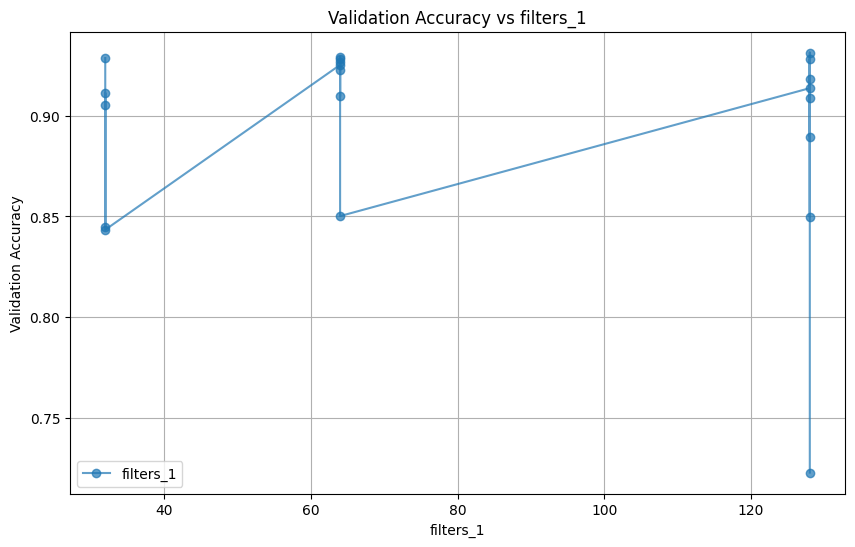

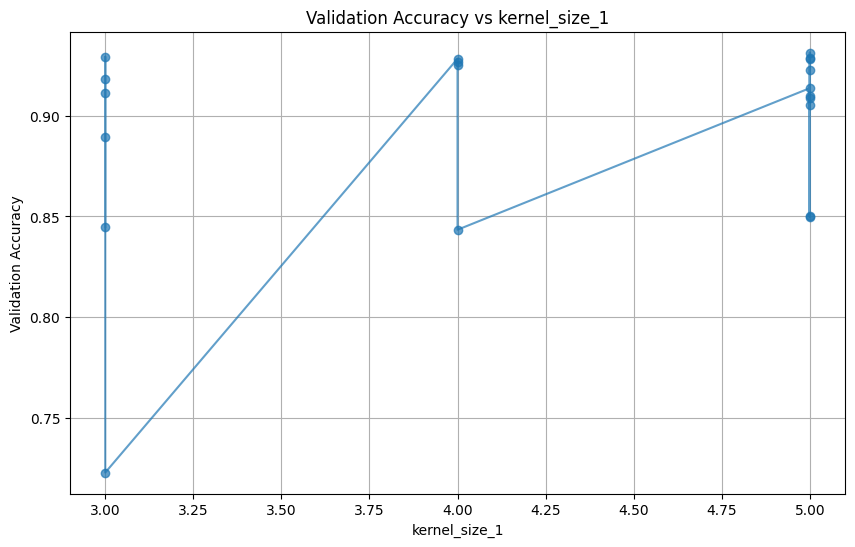

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Extract trial information from tuner
trials = tuner.oracle.trials  # Get all the trials

# Step 2: Extract relevant info for plotting
results = []
for trial in trials.values():
    # Extract hyperparameters
    trial_hyperparameters = trial.hyperparameters.values
    # Extract validation accuracy (it should be stored in the metrics)

    # Access the best value of 'val_accuracy' from the trial's metrics
    val_accuracy = trial.metrics.get_best_value('val_accuracy')  # Using get_best_value() to retrieve the metric

    if val_accuracy is not None:
        # Append hyperparameters and corresponding validation accuracy to the results
        results.append({**trial_hyperparameters, 'val_accuracy': val_accuracy})

# Step 3: Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Step 4: Create three separate line plots for each hyperparameter

# Graph 1: Plot how 'filters_1' varies with validation accuracy
if 'filters_1' in results_df.columns:
    plt.figure(figsize=(10, 6))
    # Sort the values of 'filters_1' to ensure a proper line plot
    sorted_df = results_df.sort_values('filters_1')
    plt.plot(sorted_df['filters_1'], sorted_df['val_accuracy'], marker='o', linestyle='-', label='filters_1', alpha=0.7)
    plt.xlabel('filters_1')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy vs filters_1')
    plt.grid(True)
    plt.legend()
    plt.show()

# Graph 2: Plot how 'kernel_size_1' varies with validation accuracy
if 'kernel_size_1' in results_df.columns:
    plt.figure(figsize=(10, 6))
    # Sort the values of 'kernel_size_1' to ensure a proper line plot
    sorted_df = results_df.sort_values('kernel_size_1')
    plt.plot(sorted_df['kernel_size_1'], sorted_df['val_accuracy'], marker='o', linestyle='-', label='kernel_size_1', alpha=0.7)
    plt.xlabel('kernel_size_1')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy vs kernel_size_1')
    plt.grid(True)


In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Your input variables (just for clarity)
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
# Input layer
input_layer = Input(shape=(n_timesteps, n_features))

# Best tuned Conv1D layers
x = Conv1D(filters=128, kernel_size=5, activation='relu',
           kernel_regularizer=regularizers.l2(0.001))(input_layer)
x = Conv1D(filters=128, kernel_size=4, activation='relu',
           kernel_regularizer=regularizers.l2(0.001))(x)

# Dropout + Pooling
x = Dropout(0.6)(x)
x = MaxPooling1D(pool_size=3)(x)

x = Flatten()(x)

# Dense layer
feature_layer = Dense(128, activation='relu',
                      kernel_regularizer=regularizers.l2(0.001))(x)

# Output layer
output_layer = Dense(n_outputs, activation='softmax')(feature_layer)

# Final model
final_model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
final_model.compile(loss='categorical_crossentropy',
                    optimizer=Adam(learning_rate=0.0004478774645296182),
                    metrics=['accuracy'])

# Summary
final_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 124, 128)       │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 121, 128)       │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 121, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 40, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       655,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 727,814 (2.78 MB)

 Trainable params: 727,814 (2.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
pip install pydot graphviz


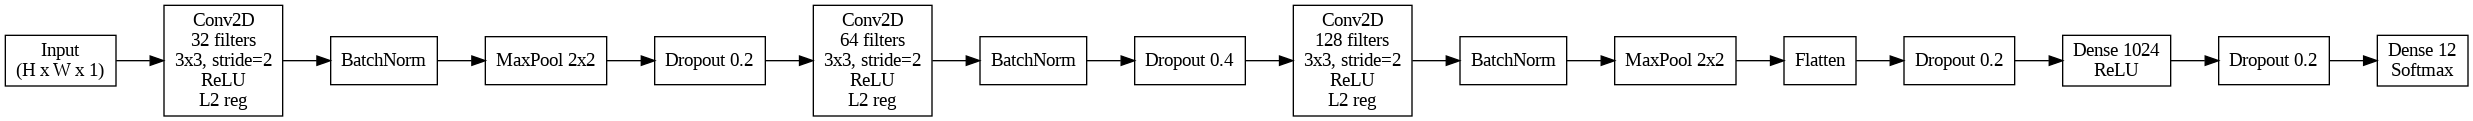

In [ ]:
from graphviz import Digraph

def draw_lenet_style_cnn():
    dot = Digraph(format='png', graph_attr={'rankdir': 'LR'})

    # Input
    dot.node('Input', 'Input\n(H x W x 1)', shape='box')

    # Conv Block 1
    dot.node('Conv1', 'Conv2D\n32 filters\n3x3, stride=2\nReLU\nL2 reg', shape='box')
    dot.node('BN1', 'BatchNorm', shape='box')
    dot.node('Pool1', 'MaxPool 2x2', shape='box')
    dot.node('Drop1', 'Dropout 0.2', shape='box')

    # Conv Block 2
    dot.node('Conv2', 'Conv2D\n64 filters\n3x3, stride=2\nReLU\nL2 reg', shape='box')
    dot.node('BN2', 'BatchNorm', shape='box')
    dot.node('Drop2', 'Dropout 0.4', shape='box')

    # Conv Block 3
    dot.node('Conv3', 'Conv2D\n128 filters\n3x3, stride=2\nReLU\nL2 reg', shape='box')
    dot.node('BN3', 'BatchNorm', shape='box')
    dot.node('Pool2', 'MaxPool 2x2', shape='box')

    # Dense Block
    dot.node('Flat', 'Flatten', shape='box')
    dot.node('Drop3', 'Dropout 0.2', shape='box')
    dot.node('Dense1', 'Dense 1024\nReLU', shape='box')
    dot.node('Drop4', 'Dropout 0.2', shape='box')
    dot.node('Out', 'Dense 12\nSoftmax', shape='box')

    # Arrows
    dot.edges([
        ('Input', 'Conv1'), ('Conv1', 'BN1'), ('BN1', 'Pool1'), ('Pool1', 'Drop1'),
        ('Drop1', 'Conv2'), ('Conv2', 'BN2'), ('BN2', 'Drop2'),
        ('Drop2', 'Conv3'), ('Conv3', 'BN3'), ('BN3', 'Pool2'),
        ('Pool2', 'Flat'), ('Flat', 'Drop3'), ('Drop3', 'Dense1'),
        ('Dense1', 'Drop4'), ('Drop4', 'Out')
    ])

    dot.render('lenet_cnn_architecture', view=True)

draw_lenet_style_cnn()
from IPython.display import Image
Image(filename='lenet_cnn_architecture.png')


In [ ]:
import time

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Start timing
start_time = time.time()

# Train the model
history = final_model.fit(
    X_train, y_train,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    batch_size=64
)

# End timing
end_time = time.time()
computation_time = end_time - start_time

# Evaluate on test data
test_loss, test_accuracy = final_model.evaluate(X_test, y_test)

# Final validation accuracy
final_val_accuracy = history.history['val_accuracy'][-1]

# Print results
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Total Computation Time: {computation_time:.2f} seconds")

# Save model
final_model.save('/content/drive/MyDrive/best_uci_cnn_model.keras')


Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.6631 - loss: 1.1997 - val_accuracy: 0.8939 - val_loss: 0.7700 - learning_rate: 4.4788e-04
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 110ms/step - accuracy: 0.9340 - loss: 0.5128 - val_accuracy: 0.9035 - val_loss: 0.6122 - learning_rate: 4.4788e-04
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.9538 - loss: 0.3983 - val_accuracy: 0.9069 - val_loss: 0.5624 - learning_rate: 4.4788e-04
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9586 - loss: 0.3480 - val_accuracy: 0.8994 - val_loss: 0.5432 - learning_rate: 4.4788e-04
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.9577 - loss: 0.3265 - val_accuracy: 0.9075 - val_loss: 0.5188 - learning_rate: 4.4788e-04
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - accuracy: 0.9603 - loss: 0.2850 - val_accuracy: 0.9137 - val_loss: 0.4704 - learning_rate: 4.4788e-04
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/ste

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
**** Classification Report ****
                    precision    recall  f1-score   support

           WALKING       1.00      0.93      0.96       496
  WALKING_UPSTAIRS       0.95      0.97      0.96       471
WALKING_DOWNSTAIRS       0.92      0.98      0.95       420
           SITTING       0.87      0.88      0.88       491
          STANDING       0.88      0.92      0.90       532
            LAYING       0.92      0.87      0.90       537

          accuracy                           0.92      2947
         macro avg       0.92      0.92      0.92      2947
      weighted avg       0.92      0.92      0.92      2947



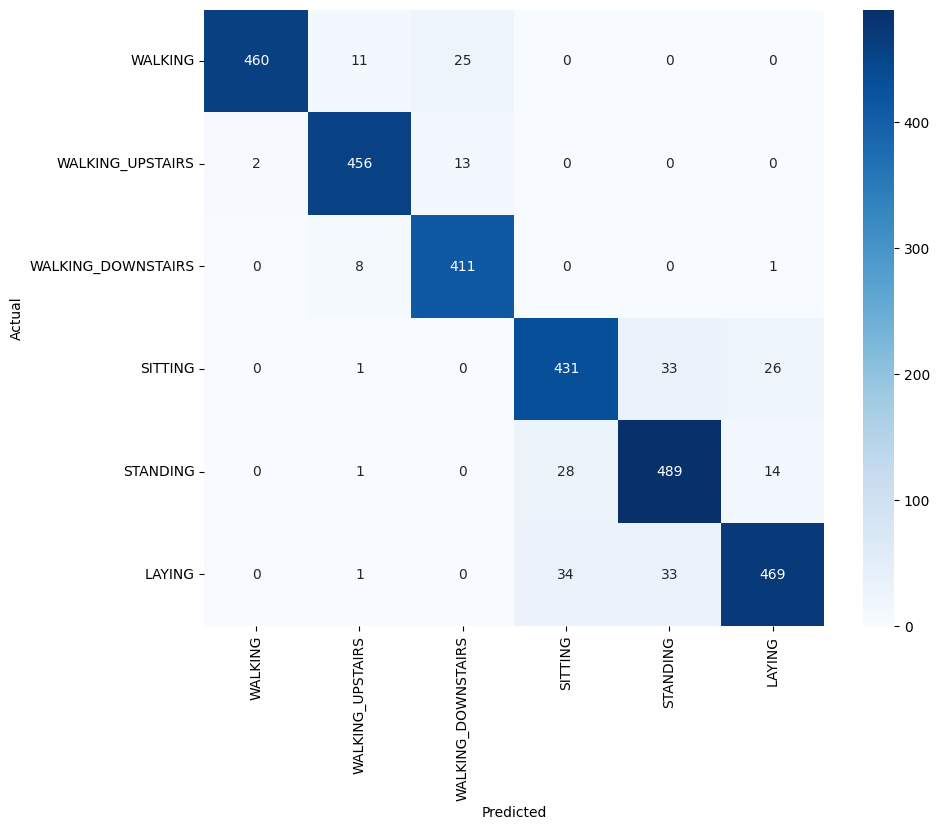

In [ ]:
predictions=final_model.predict(X_test)
classNames=['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
display_results(y_test,predictions,classNames)

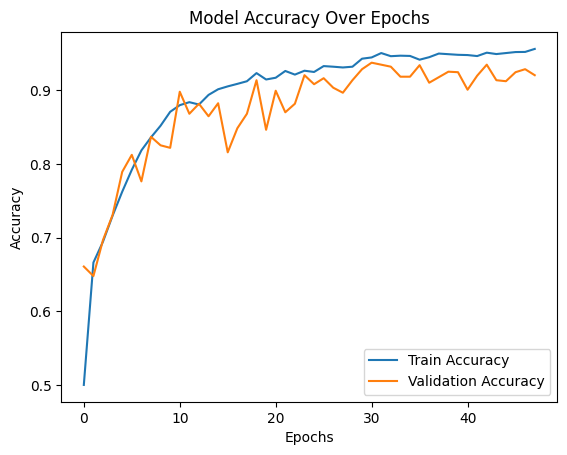

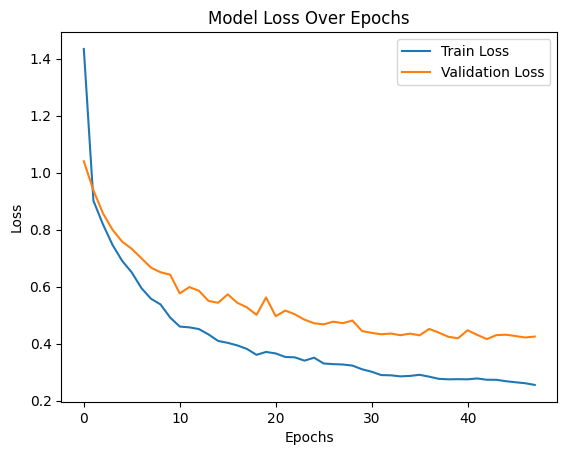

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy Over Epochs")
plt.show()
# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss Over Epochs")
plt.show()

In [ ]:
## set number of epochs and batch size
batch_size = 64
validation_split = 0.2

In [ ]:
# Input shape
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

# Define the model using Functional API
input_layer = Input(shape=(n_timesteps, n_features))  # (128, 6)

x = Conv1D(filters=64, kernel_size=4, activation='relu')(input_layer)
x = Conv1D(filters=64, kernel_size=4, activation='relu')(x)
x = Dropout(0.5)(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)

# Dense layer for feature extraction
feature_layer = Dense(100, activation='relu', name='feature_layer')(x)

# Output layer
output_layer = Dense(n_outputs, activation='softmax')(feature_layer)

# Final model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 6)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 125, 64)        │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 122, 64)        │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 122, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 61, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3904)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_layer (Dense)           │ (None, 100)            │       390,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,154 (1.56 MB)

 Trainable params: 409,154 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
train_epochs = 20
history = model.fit(X_train, y_train, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split)
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.3853 - loss: 1.3132 - val_accuracy: 0.6234 - val_loss: 0.6807
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.6556 - loss: 0.6423 - val_accuracy: 0.6485 - val_loss: 0.6296
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.6900 - loss: 0.5671 - val_accuracy: 0.6730 - val_loss: 0.5934
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.7423 - loss: 0.5234 - val_accuracy: 0.7390 - val_loss: 0.5594
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.7875 - loss: 0.4607 - val_accuracy: 0.7920 - val_loss: 0.5549
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.8340 - loss: 0.4067 - val_accuracy: 0.8566 - val_loss: 0.4696
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.8601 - loss: 0.3501 - val_accuracy: 0.8579 - val_loss: 0.4001
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.8748 - loss: 0.3210 - val_accuracy: 0.8613 - v

In [ ]:
# evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN model", test_accuracy)
predictions=model.predict(X_test)

Accuracy of the CNN model 0.876823902130127
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


**** Classification Report ****
                    precision    recall  f1-score   support

           WALKING       0.98      0.91      0.95       496
  WALKING_UPSTAIRS       0.91      0.96      0.94       471
WALKING_DOWNSTAIRS       0.94      0.97      0.96       420
           SITTING       0.83      0.77      0.80       491
          STANDING       0.73      0.94      0.83       532
            LAYING       0.93      0.73      0.82       537

          accuracy                           0.88      2947
         macro avg       0.89      0.88      0.88      2947
      weighted avg       0.89      0.88      0.88      2947



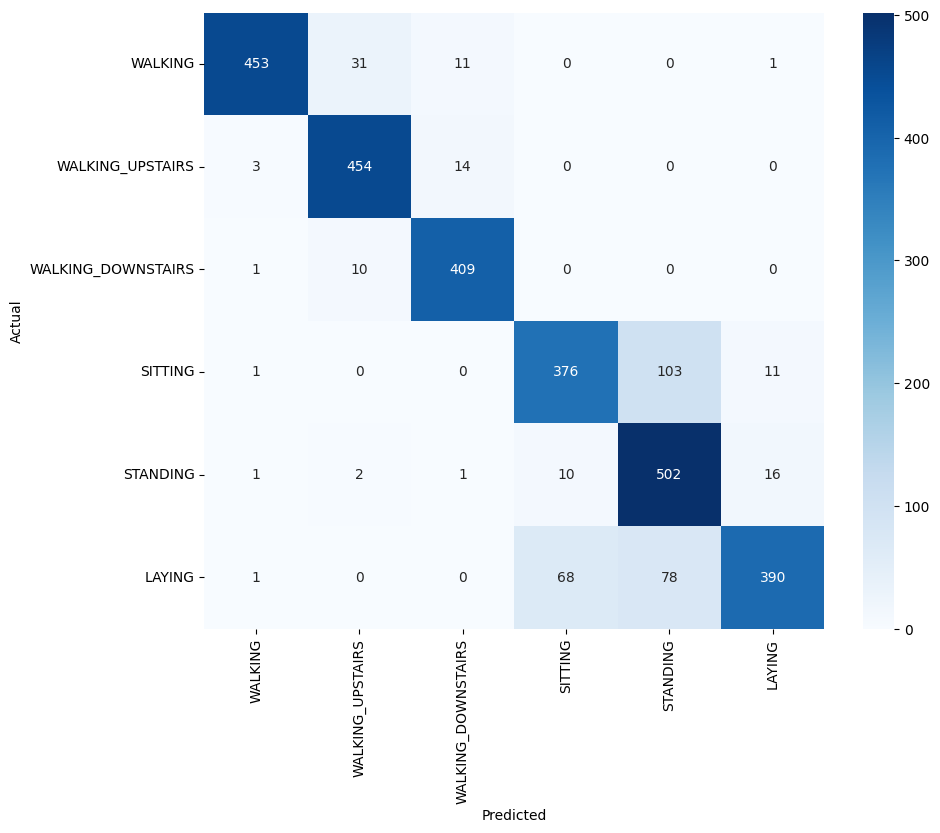

In [ ]:
classNames=['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
display_results(y_test,predictions,classNames)

In [ ]:
model.save('/content/drive/MyDrive/uci_cnn_model.keras')

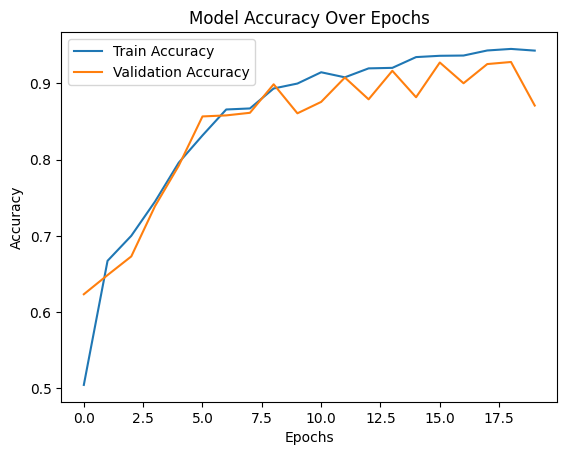

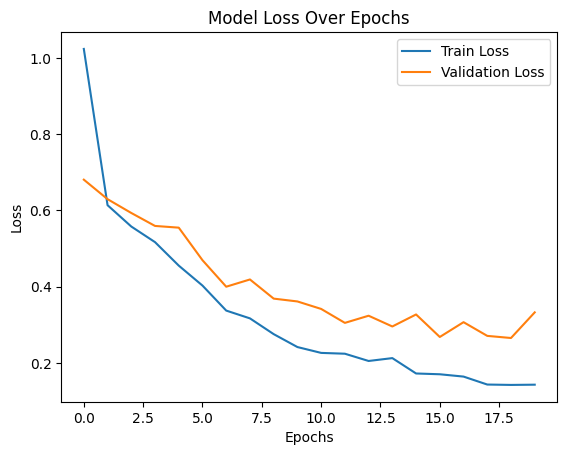

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy Over Epochs")
plt.show()
# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss Over Epochs")
plt.show()

In [ ]:
# Define dimensions
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

# Input layer
input_layer = Input(shape=(n_timesteps, n_features))

# Convolutional layers with BatchNorm and L2 regularization
x = Conv1D(64, kernel_size=4, activation='relu', kernel_regularizer=l2(0.001))(input_layer)
x = BatchNormalization()(x)

x = Conv1D(64, kernel_size=4, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)

x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)

# Dropout after flattening
x = Dropout(0.5)(x)

# Feature extraction dense layer
feature_layer = Dense(100, activation='relu', kernel_regularizer=l2(0.001), name='feature_layer')(x)

# Output layer
output_layer = Dense(n_outputs, activation='softmax')(feature_layer)

# Build the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 6)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 125, 64)        │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 125, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 122, 64)        │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 122, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 61, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3904)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3904)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_layer (Dense)           │ (None, 100)            │       390,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,666 (1.56 MB)

 Trainable params: 409,410 (1.56 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
train_epochs = 20
history = model.fit(X_train, y_train, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split)
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.4517 - loss: 1.7501 - val_accuracy: 0.1917 - val_loss: 3.3623
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.6914 - loss: 0.9248 - val_accuracy: 0.2019 - val_loss: 5.1050
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.7404 - loss: 0.8178 - val_accuracy: 0.2978 - val_loss: 4.6064
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7506 - loss: 0.7888 - val_accuracy: 0.4330 - val_loss: 2.1763
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.7778 - loss: 0.7428 - val_accuracy: 0.6818 - val_loss: 0.9587
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.7819 - loss: 0.7107 - val_accuracy: 0.7274 - val_loss: 0.8963
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step - accuracy: 0.8220 - loss: 0.6436 - val_accuracy: 0.8049 - val_loss: 0.7236
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8110 - loss: 0.6398 - val_accuracy: 0.6744 -

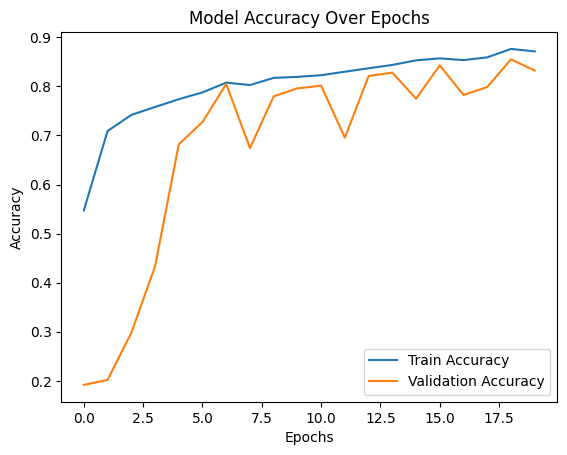

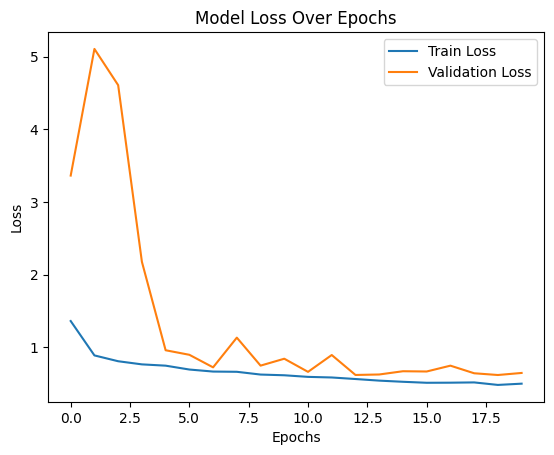

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy Over Epochs")
plt.show()
# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss Over Epochs")
plt.show()

In [ ]:
# evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN model", test_accuracy)
predictions=model.predict(X_test)

Accuracy of the CNN model 0.817441463470459
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [ ]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

input_layer = Input(shape=(n_timesteps, n_features))
x = Conv1D(64, 4, activation='relu')(input_layer)
x = Conv1D(64, 4, activation='relu')(x)
x = Conv1D(64, 4, activation='relu')(x)
x = Dropout(0.5)(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
feature_layer = Dense(100, activation='relu', name='feature_layer')(x)
output_layer = Dense(n_outputs, activation='softmax')(feature_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 6)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 125, 64)        │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 122, 64)        │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 119, 64)        │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 119, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 59, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3776)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_layer (Dense)           │ (None, 100)            │       377,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 412,802 (1.57 MB)

 Trainable params: 412,802 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train like before
model.fit(X_train, y_train, epochs=20, batch_size=batch_size, validation_split=0.2)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/20
368/368 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.4542 - loss: 1.0776 - val_accuracy: 0.6513 - val_loss: 0.6385
Epoch 2/20
368/368 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.6654 - loss: 0.5898 - val_accuracy: 0.6764 - val_loss: 0.5948
Epoch 3/20
368/368 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.7160 - loss: 0.5662 - val_accuracy: 0.8001 - val_loss: 0.5163
Epoch 4/20
368/368 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.7821 - loss: 0.4592 - val_accuracy: 0.8314 - val_loss: 0.4330
Epoch 5/20
368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.8382 - loss: 0.3594 - val_accuracy: 0.8158 - val_loss: 0.4834
Epoch 6/20
368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8543 - loss: 0.3393 - val_accuracy: 0.8906 - val_loss: 0.3561
Epoch 7/20
368/368 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.8839 - loss: 0.2774 - val_accuracy: 0.8919 - val_loss: 0.2994
Epoch 8/20
368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.8928 - loss: 0.2674 - val_a

In [ ]:
# evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN model", test_accuracy)
predictions=model.predict(X_test)

Accuracy of the CNN model 0.8866643905639648
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


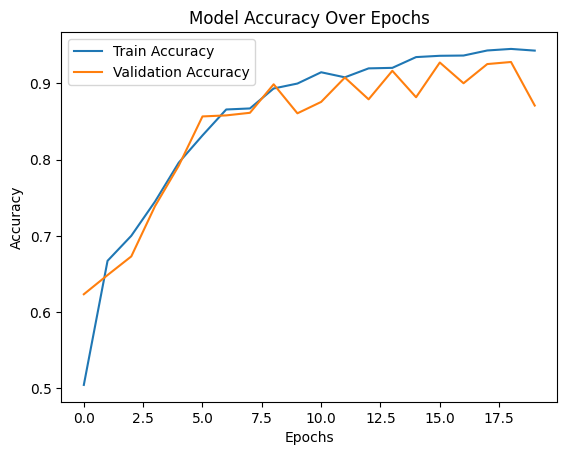

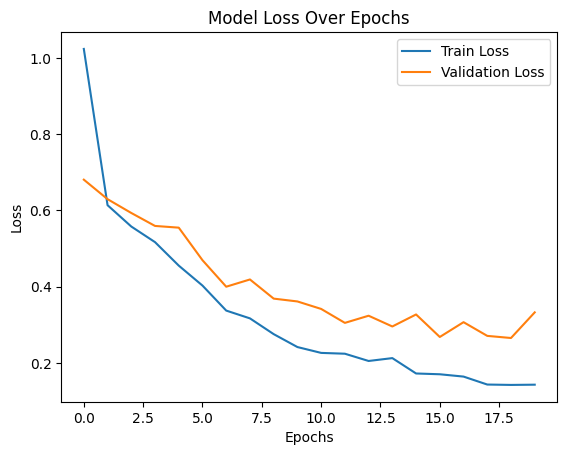

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy Over Epochs")
plt.show()
# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss Over Epochs")
plt.show()

**** Classification Report ****
                    precision    recall  f1-score   support

           WALKING       0.99      0.86      0.92       496
  WALKING_UPSTAIRS       0.84      0.96      0.90       471
WALKING_DOWNSTAIRS       0.91      0.93      0.92       420
           SITTING       0.81      0.90      0.85       491
          STANDING       0.87      0.89      0.88       532
            LAYING       0.94      0.80      0.87       537

          accuracy                           0.89      2947
         macro avg       0.89      0.89      0.89      2947
      weighted avg       0.89      0.89      0.89      2947



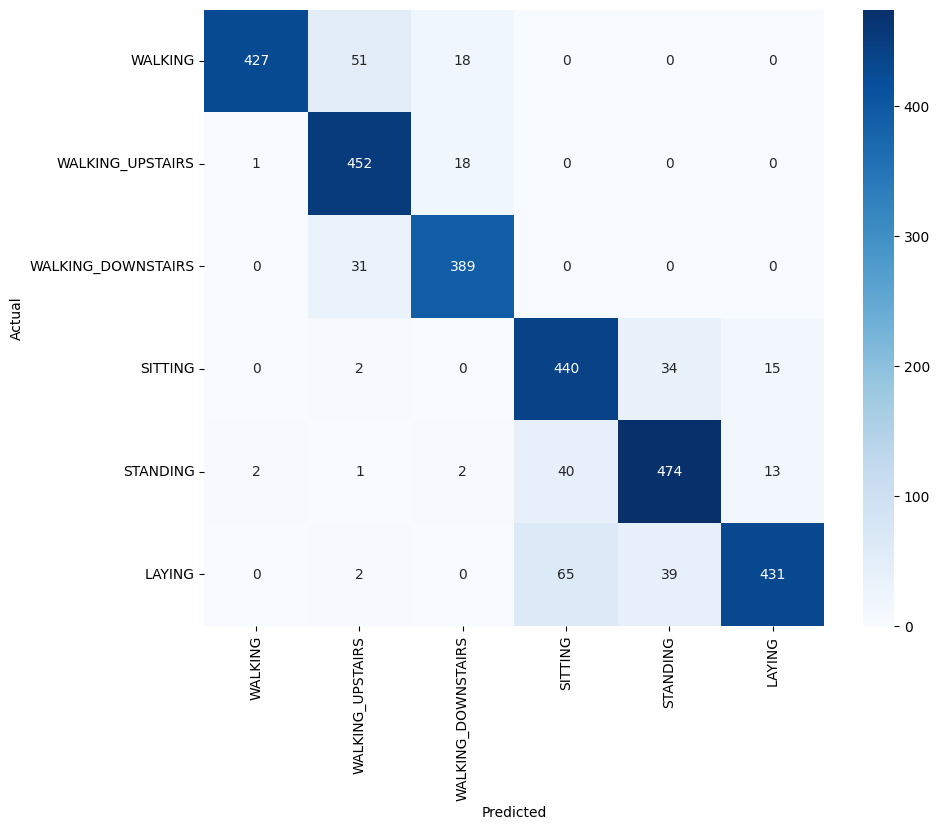

In [ ]:
classNames=['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
display_results(y_test,predictions,classNames)

In [ ]:
model.save('/content/drive/MyDrive/uci_cnn_model2.keras')

# **CNN FEATURE EXTRACTION**

In [ ]:
# Load the model from Google Drive
model = load_model('/content/drive/MyDrive/best_uci_cnn_model.keras')

In [ ]:
# Then for feature extraction:
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('dense').output)
features_train = feature_extractor.predict(X_train)
features_test = feature_extractor.predict(X_test)

230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [ ]:
print("Extracted Train Features Shape:", features_train.shape)  # Expected: (num_samples, 128)
print("Extracted Test Features Shape:", features_test.shape)

Extracted Train Features Shape: (7352, 128)
Extracted Test Features Shape: (2947, 128)


# **TRAINING THE ML MODELS**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import numpy as np

# Convert one-hot to class labels
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Train Random Forest
clf = RandomForestClassifier(n_estimators=100)
clf.fit(features_train, y_train_labels)

# Predict
y_pred = clf.predict(features_test)

# Evaluate
acc = accuracy_score(y_test_labels, y_pred)
f1 = f1_score(y_test_labels, y_pred, average='weighted')
recall = recall_score(y_test_labels, y_pred, average='weighted')
precision = precision_score(y_test_labels, y_pred, average='weighted')

# Print results
print(f"Random Forest Accuracy:  {acc:.4f}")
print(f"F1 Score:               {f1:.4f}")
print(f"Recall:                 {recall:.4f}")
print(f"Precision:              {precision:.4f}")


Random Forest Accuracy:  0.9179
F1 Score:               0.9179
Recall:                 0.9179
Precision:              0.9198


In [ ]:
# Convert one-hot to label indices
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Train Linear SVC (LVC)
svc = LinearSVC(max_iter=10000)  # increase max_iter to ensure convergence
svc.fit(features_train, y_train_labels)

# Predict
y_pred = svc.predict(features_test)
# Evaluate
acc = accuracy_score(y_test_labels, y_pred)
f1 = f1_score(y_test_labels, y_pred, average='weighted')
recall = recall_score(y_test_labels, y_pred, average='weighted')
precision = precision_score(y_test_labels, y_pred, average='weighted')

## Print results
print(f"Random Forest Accuracy:  {acc:.4f}")
print(f"F1 Score:               {f1:.4f}")
print(f"Recall:                 {recall:.4f}")
print(f"Precision:              {precision:.4f}")


Random Forest Accuracy:  0.9118
F1 Score:               0.9118
Recall:                 0.9118
Precision:              0.9130


In [ ]:
svm = SVC(kernel='rbf')  # default is 'rbf'
svm.fit(features_train, y_train_labels)
y_pred = svm.predict(features_test)
# Evaluate
acc = accuracy_score(y_test_labels, y_pred)
f1 = f1_score(y_test_labels, y_pred, average='weighted')
recall = recall_score(y_test_labels, y_pred, average='weighted')
precision = precision_score(y_test_labels, y_pred, average='weighted')

# Print results
print(f"Random Forest Accuracy:  {acc:.4f}")
print(f"F1 Score:               {f1:.4f}")
print(f"Recall:                 {recall:.4f}")
print(f"Precision:              {precision:.4f}")


Random Forest Accuracy:  0.9175
F1 Score:               0.9175
Recall:                 0.9175
Precision:              0.9194


In [ ]:
xgb = XGBClassifier( eval_metric='mlogloss')
xgb.fit(features_train, y_train_labels)
y_pred = xgb.predict(features_test)
# Evaluate
acc = accuracy_score(y_test_labels, y_pred)
f1 = f1_score(y_test_labels, y_pred, average='weighted')
recall = recall_score(y_test_labels, y_pred, average='weighted')
precision = precision_score(y_test_labels, y_pred, average='weighted')

# Print results
print(f"Random Forest Accuracy:  {acc:.4f}")
print(f"F1 Score:               {f1:.4f}")
print(f"Recall:                 {recall:.4f}")
print(f"Precision:              {precision:.4f}")


Random Forest Accuracy:  0.9189
F1 Score:               0.9189
Recall:                 0.9189
Precision:              0.9206


In [ ]:
mlr = LogisticRegression(solver='lbfgs', max_iter=1000)
mlr.fit(features_train, y_train_labels)
y_pred = mlr.predict(features_test)
# Evaluate
acc = accuracy_score(y_test_labels, y_pred)
f1 = f1_score(y_test_labels, y_pred, average='weighted')
recall = recall_score(y_test_labels, y_pred, average='weighted')
precision = precision_score(y_test_labels, y_pred, average='weighted')

# Print results
print(f"Random Forest Accuracy:  {acc:.4f}")
print(f"F1 Score:               {f1:.4f}")
print(f"Recall:                 {recall:.4f}")
print(f"Precision:              {precision:.4f}")

Random Forest Accuracy:  0.9080
F1 Score:               0.9080
Recall:                 0.9080
Precision:              0.9094


In [ ]:
# Initialize the Decision Tree
dtree = DecisionTreeClassifier(random_state=42)

# Train
dtree.fit(features_train, y_train_labels)

# Predict
y_pred = dtree.predict(features_test)

# Evaluate
acc = accuracy_score(y_test_labels, y_pred)
f1 = f1_score(y_test_labels, y_pred, average='weighted')
recall = recall_score(y_test_labels, y_pred, average='weighted')
precision = precision_score(y_test_labels, y_pred, average='weighted')

# Print results
print(f"Random Forest Accuracy:  {acc:.4f}")
print(f"F1 Score:               {f1:.4f}")
print(f"Recall:                 {recall:.4f}")
print(f"Precision:              {precision:.4f}")


Random Forest Accuracy:  0.8894
F1 Score:               0.8896
Recall:                 0.8894
Precision:              0.8915


# **FEATURE SELECTION USING EMBEDDED TECHNIQUES**

In [ ]:
X_train_cnn = features_train
X_test_cnn = features_test

In [ ]:
# Convert from one-hot to label encoding
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)


In [ ]:
# 1. Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_cnn)
X_test_scaled = scaler.transform(X_test_cnn)

# 2. L1-penalized logistic regression (Lasso)
lasso = LogisticRegression(
    penalty='l1',
    solver='liblinear',  # required for L1
    C=0.01,
    max_iter=500,
    random_state=42
)

selector_lasso = SelectFromModel(lasso).fit(X_train_scaled, y_train_labels)

# 3. Transform features
X_train_lasso = selector_lasso.transform(X_train_scaled)
X_test_lasso = selector_lasso.transform(X_test_scaled)

# 4. Train classifier on selected features
model = LogisticRegression(max_iter=500, random_state=42)
model.fit(X_train_lasso, y_train_labels)
y_pred = model.predict(X_test_lasso)

# 5. Results
print("Lasso-selected features:", X_train_lasso.shape[1])
print("Accuracy with Lasso-selected features:", accuracy_score(y_test_labels, y_pred))


Lasso-selected features: 39
Accuracy with Lasso-selected features: 0.9080420766881574


In [ ]:
X_train_lasso.shape

(7352, 39)

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_lasso, y_train_labels)
y_pred_rf = rf.predict(X_test_lasso)
print("Random Forest Accuracy:", accuracy_score(y_test_labels, y_pred_rf))
print("Random Forest Report:\n", classification_report(y_test_labels, y_pred_rf))

Random Forest Accuracy: 0.9199185612487275
Random Forest Report:
               precision    recall  f1-score   support

           0       0.99      0.92      0.95       496
           1       0.93      0.97      0.95       471
           2       0.95      0.98      0.97       420
           3       0.88      0.86      0.87       491
           4       0.86      0.93      0.89       532
           5       0.93      0.87      0.90       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



In [ ]:
svm = SVC(kernel='rbf', C=1, random_state=42)
svm.fit(X_train_lasso, y_train_labels)
y_pred_svm = svm.predict(X_test_lasso)
print("SVM Accuracy:", accuracy_score(y_test_labels, y_pred_svm))
print("SVM Report:\n", classification_report(y_test_labels, y_pred_svm))

SVM Accuracy: 0.9134713267729895
SVM Report:
               precision    recall  f1-score   support

           0       0.98      0.93      0.96       496
           1       0.93      0.96      0.94       471
           2       0.94      0.97      0.96       420
           3       0.86      0.87      0.87       491
           4       0.85      0.92      0.89       532
           5       0.93      0.85      0.88       537

    accuracy                           0.91      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.91      0.91      2947



In [ ]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_lasso, y_train_labels)
y_pred_xgb = xgb.predict(X_test_lasso)

print("XGBoost Accuracy:", accuracy_score(y_test_labels, y_pred_xgb))
print("XGBoost Report:\n", classification_report(y_test_labels, y_pred_xgb))

XGBoost Accuracy: 0.9165252799457075
XGBoost Report:
               precision    recall  f1-score   support

           0       0.99      0.92      0.95       496
           1       0.92      0.96      0.94       471
           2       0.94      0.99      0.96       420
           3       0.87      0.86      0.87       491
           4       0.86      0.93      0.89       532
           5       0.94      0.86      0.90       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_lasso, y_train_labels)
y_pred_knn = knn.predict(X_test_lasso)
print("KNN Accuracy:", accuracy_score(y_test_labels, y_pred_knn))
print("KNN Report:\n", classification_report(y_test_labels, y_pred_knn))


KNN Accuracy: 0.9144893111638955
KNN Report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.96       496
           1       0.94      0.96      0.95       471
           2       0.95      0.97      0.96       420
           3       0.86      0.86      0.86       491
           4       0.85      0.94      0.89       532
           5       0.93      0.84      0.88       537

    accuracy                           0.91      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.91      0.91      2947



In [ ]:
lvc = LinearSVC(max_iter=1000, random_state=42)
lvc.fit(X_train_lasso, y_train_labels)
y_pred_lvc = lvc.predict(X_test_lasso)

print("Linear SVM (LVC) Accuracy:", accuracy_score(y_test_labels, y_pred_lvc))
print("LVC Report:\n", classification_report(y_test_labels, y_pred_lvc))


Linear SVM (LVC) Accuracy: 0.9114353579911775
LVC Report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.95       496
           1       0.94      0.94      0.94       471
           2       0.92      0.97      0.95       420
           3       0.87      0.87      0.87       491
           4       0.86      0.92      0.89       532
           5       0.92      0.85      0.88       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



In [ ]:
mlr = LogisticRegression(solver='lbfgs', max_iter=500, random_state=42)
mlr.fit(X_train_lasso, y_train_labels)
y_pred_mlr = mlr.predict(X_test_lasso)

print("Multinomial Logistic Regression Accuracy:", accuracy_score(y_test_labels, y_pred_mlr))
print("MLR Report:\n", classification_report(y_test_labels, y_pred_mlr))


Multinomial Logistic Regression Accuracy: 0.9080420766881574
MLR Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95       496
           1       0.93      0.94      0.94       471
           2       0.92      0.95      0.94       420
           3       0.85      0.88      0.87       491
           4       0.86      0.92      0.89       532
           5       0.92      0.84      0.88       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



# **FEATURE SELECTION USING TREE TECHNIQUES**

In [ ]:
X_train_cnn = features_train
X_test_cnn = features_test

In [ ]:
# Convert from one-hot to label encoding
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

Top 20 Features → Accuracy: 0.8931
Top 40 Features → Accuracy: 0.9080
Top 60 Features → Accuracy: 0.9104
Top 80 Features → Accuracy: 0.9155
Top 100 Features → Accuracy: 0.9206
Top 128 Features → Accuracy: 0.9192


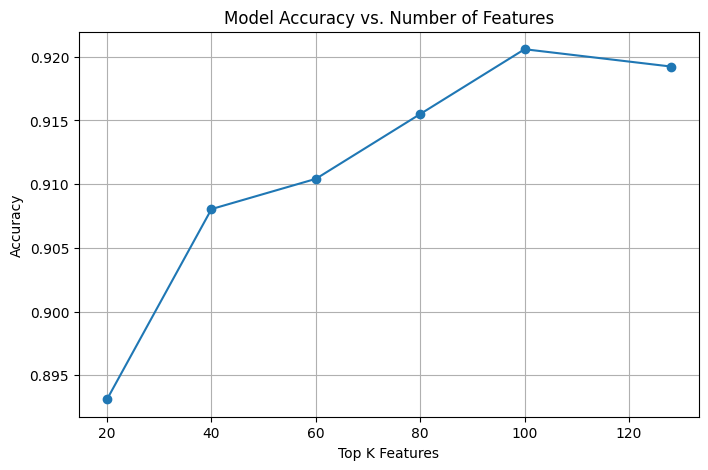

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_cnn, y_train_labels)

importances = rf.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

# 3. Try top-k feature subsets
top_ks = [20, 40, 60, 80, 100,128]
accuracies = []

for k in top_ks:

    selected_indices = sorted_indices[:k]
    # Ensure selected_indices only includes valid column indices
    selected_indices = [i for i in selected_indices if i < X_train_scaled.shape[1]]

    # Subset the data
    X_train_k = X_train_scaled[:, selected_indices]
    X_test_k = X_test_scaled[:, selected_indices]

    # Train and evaluate
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train_k, y_train_labels)
    y_pred_k = clf.predict(X_test_k)

    acc = accuracy_score(y_test_labels, y_pred_k)
    accuracies.append(acc)
    print(f"Top {k} Features → Accuracy: {acc:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(top_ks, accuracies, marker='o')
plt.title("Model Accuracy vs. Number of Features")
plt.xlabel("Top K Features")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


Top 20 Features → Accuracy: 0.9135
Top 40 Features → Accuracy: 0.9121
Top 60 Features → Accuracy: 0.9155
Top 80 Features → Accuracy: 0.9108
Top 100 Features → Accuracy: 0.9125


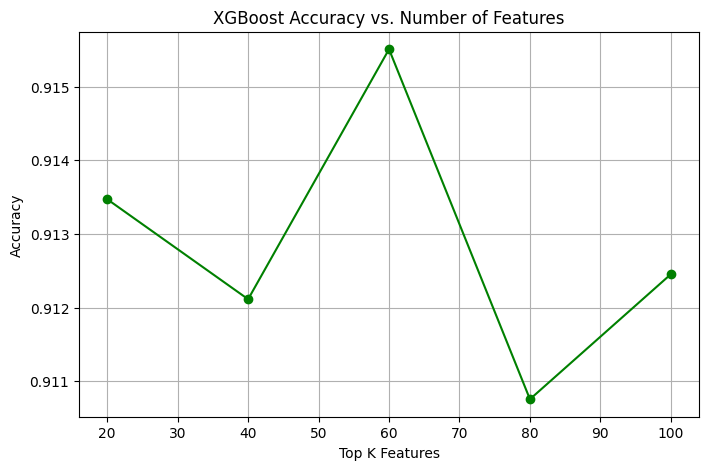

In [ ]:
# Fit XGBoost on full scaled training set
xgb_full = XGBClassifier(random_state=42)
xgb_full.fit(X_train_scaled, y_train_labels)

# Get feature importances (gain-based by default)
importances = xgb_full.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

top_ks = [20, 40, 60, 80, 100]
accuracies = []

for k in top_ks:
    selected_indices = sorted_indices[:k]

    # Subset the features
    X_train_k = X_train_scaled[:, selected_indices]
    X_test_k = X_test_scaled[:, selected_indices]

    # Train model
    xgb = XGBClassifier(random_state=42)
    xgb.fit(X_train_k, y_train_labels)
    y_pred_k = xgb.predict(X_test_k)

    # Evaluate
    acc = accuracy_score(y_test_labels, y_pred_k)
    accuracies.append(acc)
    print(f"Top {k} Features → Accuracy: {acc:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(top_ks, accuracies, marker='o', color='green')
plt.title("XGBoost Accuracy vs. Number of Features")
plt.xlabel("Top K Features")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()



Top 20 Features → Accuracy: 0.9145
Top 40 Features → Accuracy: 0.9175
Top 60 Features → Accuracy: 0.9172
Top 80 Features → Accuracy: 0.9172
Top 100 Features → Accuracy: 0.9179


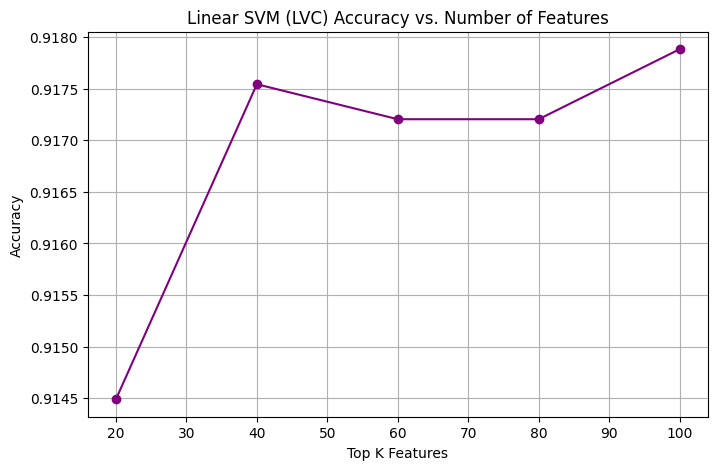

In [ ]:
# Train on full feature set
lvc_full = LinearSVC(max_iter=1000, random_state=42)
lvc_full.fit(X_train_scaled, y_train_labels)

# Get absolute coefficients (importance)
coef = np.abs(lvc_full.coef_)
importance = np.mean(coef, axis=0)  # for multi-class
sorted_indices = np.argsort(importance)[::-1]

top_ks = [20, 40, 60, 80, 100]
accuracies = []

for k in top_ks:
    selected_indices = sorted_indices[:k]

    # Subset data
    X_train_k = X_train_scaled[:, selected_indices]
    X_test_k = X_test_scaled[:, selected_indices]

    # Train model
    lvc_k = LinearSVC(max_iter=1000, random_state=42)
    lvc_k.fit(X_train_k, y_train_labels)
    y_pred_k = lvc_k.predict(X_test_k)

    acc = accuracy_score(y_test_labels, y_pred_k)
    accuracies.append(acc)
    print(f"Top {k} Features → Accuracy: {acc:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(top_ks, accuracies, marker='o', color='purple')
plt.title("Linear SVM (LVC) Accuracy vs. Number of Features")
plt.xlabel("Top K Features")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


Top 20 Features → Accuracy: 0.8907
Top 40 Features → Accuracy: 0.9135
Top 60 Features → Accuracy: 0.9158
Top 80 Features → Accuracy: 0.9165
Top 100 Features → Accuracy: 0.9158


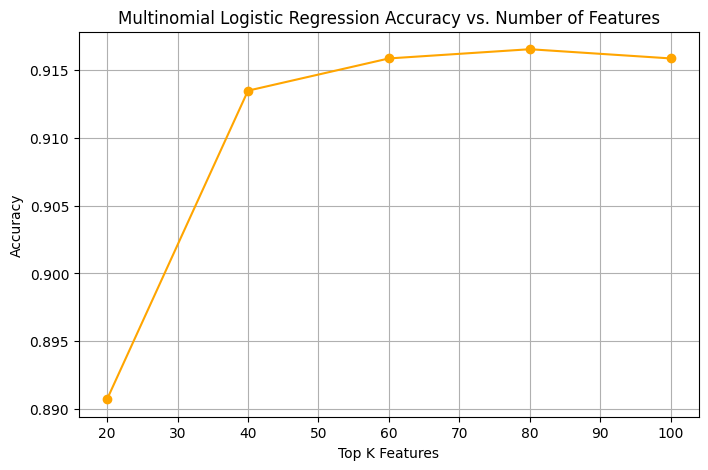

In [ ]:
# Fit full MLR model on all features
mlr_full = LogisticRegression(solver='lbfgs', max_iter=500, random_state=42)
mlr_full.fit(X_train_scaled, y_train_labels)

# Compute importance from coefficients
coef = np.abs(mlr_full.coef_)
importance = np.mean(coef, axis=0)  # average across classes
sorted_indices = np.argsort(importance)[::-1]

top_ks = [20, 40, 60, 80, 100]
accuracies = []

for k in top_ks:
    selected_indices = sorted_indices[:k]

    # Subset data
    X_train_k = X_train_scaled[:, selected_indices]
    X_test_k = X_test_scaled[:, selected_indices]

    # Train model
    mlr_k = LogisticRegression( solver='lbfgs', max_iter=500, random_state=42)
    mlr_k.fit(X_train_k, y_train_labels)
    y_pred_k = mlr_k.predict(X_test_k)

    acc = accuracy_score(y_test_labels, y_pred_k)
    accuracies.append(acc)
    print(f"Top {k} Features → Accuracy: {acc:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(top_ks, accuracies, marker='o', color='orange')
plt.title("Multinomial Logistic Regression Accuracy vs. Number of Features")
plt.xlabel("Top K Features")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


#  **FEATURE SELECTION USING FILTERING METHODS**


Variance Threshold:
 → Selected 111 features: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110]
 → Accuracy: 0.9216

Chi-Squared:
 → Selected 40 features: [  2   6   8   9  10  12  16  19  31  32  33  36  38  39  42  44  45  47
  48  52  53  55  56  58  59  68  69  71  72  74  79  80  84  87  90  92
  94  96  98 110]
 → Accuracy: 0.9118

ANOVA F-test:
 → Selected 40 features: [  0   1   2   9  10  12  16  18  22  23  24  32  33  39  42  44  45  47
  48  50  55  56  58  59  68  69  72  73  74  77  79  80  84  90  92  94
  96  98 104 106]
 → Accuracy: 0.9091

Mutual Information:
 → Selected 4

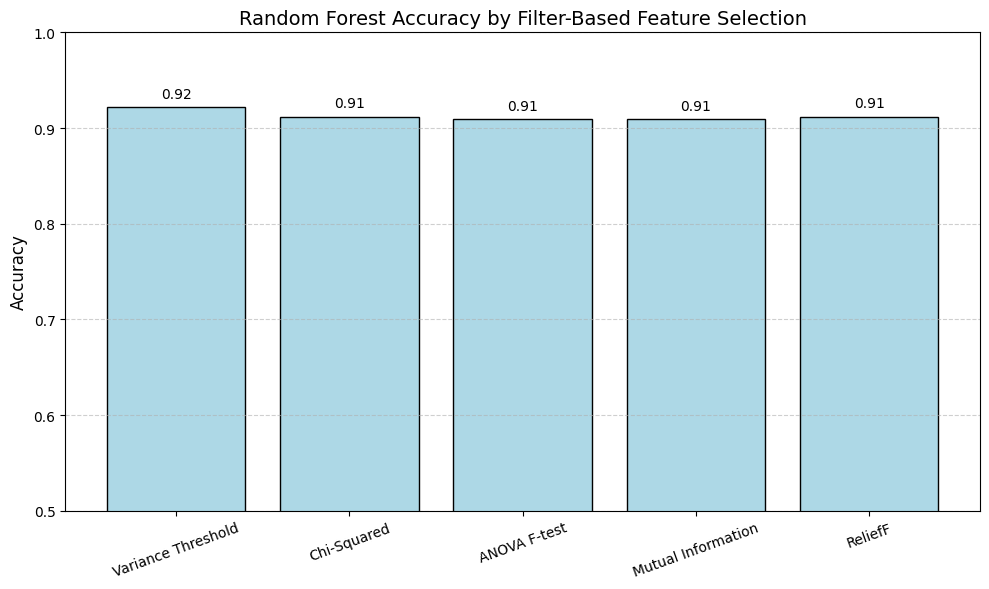

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_selection import (
    VarianceThreshold, SelectKBest, chi2, f_classif, mutual_info_classif
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from skrebate import ReliefF

# === STEP 1: Remove near-constant features ===
vt = VarianceThreshold(threshold=0.01)
X_train_no_const = vt.fit_transform(X_train_cnn)
X_test_no_const = vt.transform(X_test_cnn)

# === STEP 2: Scale data for methods that need it ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_no_const)
X_test_scaled = scaler.transform(X_test_no_const)

# === STEP 3: Define filter methods ===
def get_methods(X_train_mod):
    n_features = min(80, X_train_mod.shape[1])  # Don't request more than available
    return {
        'Variance Threshold': lambda X, y: VarianceThreshold(threshold=0.01).fit(X),
        'Chi-Squared': lambda X, y: SelectKBest(score_func=chi2, k=n_features).fit(X, y),
        'ANOVA F-test': lambda X, y: SelectKBest(score_func=f_classif, k=n_features).fit(X, y),
        'Mutual Information': lambda X, y: SelectKBest(score_func=mutual_info_classif, k=n_features).fit(X, y),
        'ReliefF': lambda X, y: ReliefF(n_neighbors=10, n_features_to_select=n_features).fit(X, y)
    }

# === STEP 4: Evaluate each method with Random Forest ===
accuracies = {}
methods = get_methods(X_train_scaled)

for name, selector_func in methods.items():
    print(f"\n{name}:")

    # Prepare data for specific method
    if name == 'Chi-Squared':
        # chi2 needs non-negative features
        X_train_mod = X_train_no_const - X_train_no_const.min(axis=0)
        X_test_mod = X_test_no_const - X_train_no_const.min(axis=0)
    elif name == 'ReliefF':
        X_train_mod = X_train_scaled
        X_test_mod = X_test_scaled
    else:
        X_train_mod = X_train_scaled
        X_test_mod = X_test_scaled

    # Apply feature selection
    selector = selector_func(X_train_mod, y_train_labels)
    X_train_sel = selector.transform(X_train_mod)
    X_test_sel = selector.transform(X_test_mod)

    # Output number of selected features
    if hasattr(selector, 'get_support'):
        selected_indices = np.where(selector.get_support())[0]
        print(f" → Selected {len(selected_indices)} features: {selected_indices}")
    else:
        print(f" → Selected {X_train_sel.shape[1]} features (no get_support method).")

    # Train classifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train_sel, y_train_labels)
    y_pred = rf.predict(X_test_sel)

    # Evaluate
    acc = accuracy_score(y_test_labels, y_pred)
    accuracies[name] = acc
    print(f" → Accuracy: {acc:.4f}")

# === STEP 5: Plot accuracy results ===
plt.figure(figsize=(10, 6))
bars = plt.bar(accuracies.keys(), accuracies.values(), color='lightblue', edgecolor='black')
plt.title("Random Forest Accuracy by Filter-Based Feature Selection", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(rotation=20, fontsize=10)
plt.ylim(0.5, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Annotate bar heights
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
!pip install skrebate

  Preparing metadata (setup.py) ... done
  Created wheel for skrebate: filename=skrebate-0.62-py3-none-any.whl size=29253 sha256=09e6aea30e3c4d9e735a82435f57d688d262074b7772e40a632b8fccc58353a0
  Stored in directory: /root/.cache/pip/wheels/8a/d2/67/8368fca718041057b33d6448ca526aaf1ce2e404c94b901e41
Successfully built skrebate
